In [1]:
1*2

2

In [2]:
import importlib
def rl():
    importlib.reload(Di)

In [3]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [4]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
import torch
import gpytorch

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import Di

### Read genotype and phenotypes

In [6]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]

env_list = sorted(env_list)

In [7]:
env = env_list[5]
print(env)

NaCl


In [8]:
df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')

In [9]:
ids = list(df.columns[3:])

In [10]:
env + '_matsui_geno_t.pt'

'NaCl_matsui_geno_t.pt'

In [11]:
geno_t = torch.load(env + '_matsui_geno_t.pt')

In [12]:
geno_t

tensor([[1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        [1., 2., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.],
        [1., 2., 2.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

In [13]:
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

In [14]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")

In [15]:
pheno = pheno.set_index('geno')

In [16]:
pheno = pheno.loc[ids]

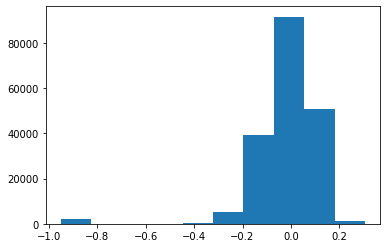

In [17]:
plt.hist(pheno.pheno)
plt.show()

### Set up Di kernel

In [18]:
n_devices = torch.cuda.device_count()
output_device = torch.device('cuda:0')
print('Planning to run on {} GPUs.'.format(n_devices))

Di.n_devices = n_devices
Di.output_device = output_device

Di.N, Di.L = geno_t.shape

Planning to run on 8 GPUs.


### Training and test data

In [19]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

In [20]:
np.random.seed(100)

In [21]:
sub = np.random.choice(inds_sub, 40000)

sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5000)

In [22]:
train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

In [23]:
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

### Di kernel

In [50]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.DiGPModel(train_x, train_y, likelihood)
model.covar_module.module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model = model.to(output_device).double()

In [51]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [52]:
model.train()
output = model(train_x)

model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=300, lr=.015)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180
200
220
240
260
280


In [53]:
print(model.covar_module.module.raw_lda, model.covar_module.module.raw_eta)

Parameter containing:
tensor(-11.1033, device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor(-15.2565, device='cuda:0', dtype=torch.float64, requires_grad=True)


In [54]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.beta_features.checkpoint_kernel(0):
    # Make predictions on a small number of test points to get the test time caches computed
    f_preds = model(test_x)


In [55]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

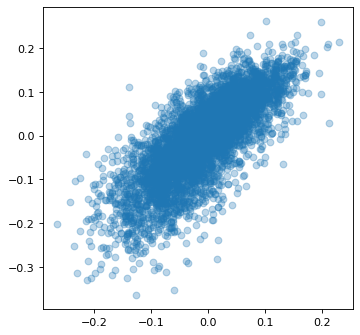

r2 = 0.600603
R2 = 0.600329
mse = 0.003365


In [56]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### Linear kernel

In [32]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.LinGPModel(train_x, train_y, likelihood)
model = model.to(output_device).double()

In [33]:
ker = Di.LinKernel()

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [35]:
model.train()
output = model(train_x)

model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=20, lr=.01)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


In [36]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

f_preds = model(test_x)

In [37]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

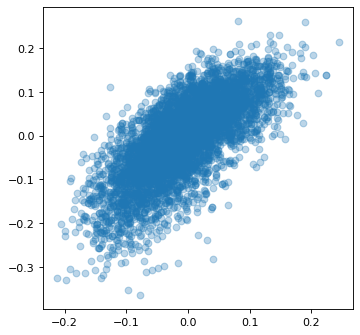

r2 = 0.517368
R2 = 0.516843
mse = 0.004068


In [38]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### RBF kernel

In [57]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.RBFGPModel(train_x, train_y, likelihood)
model = model.to(output_device).double()

In [58]:
optimizer = torch.optim.AdamW(model.parameters(), .02)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [59]:
model.train()
output = model(train_x)

model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=200, lr=.01)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180


In [60]:
test_x = test_x.cuda()
model.eval()
likelihood.eval()

f_preds = model(test_x)

In [61]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

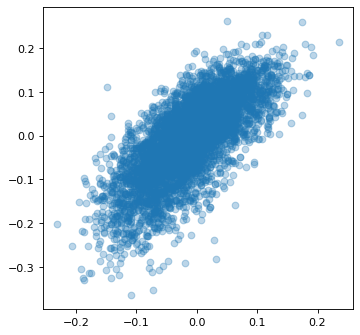

r2 = 0.534380
R2 = 0.530203
mse = 0.003955


In [62]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

In [45]:
1*2

2

In [48]:
np.sqrt(0.540694)

0.7353189784032506

In [49]:
np.sqrt(0.585600)

0.7652450587883597

### Linear regression

In [67]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_x.cpu().numpy(), train_y.cpu().numpy())

In [70]:
f_mean = reg.predict(test_x.cpu().numpy())

In [71]:
y_test = test_y.detach().cpu().numpy()

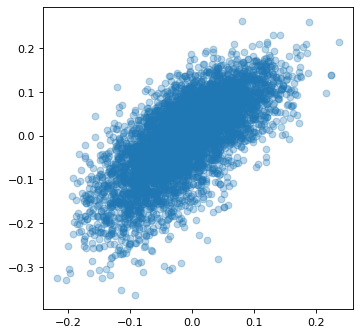

r2 = 0.497869
R2 = 0.494443
mse = 0.004256


In [72]:
# epistatic
figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### LMM

In [74]:
# import the algorithm
import numpy as np
from fastlmm.association import single_snp
from fastlmm.util import example_file # Download and return local file name


In [285]:

# set up data
##############################
from fastlmm.util import example_file # Download and return local file name
bed_fn = example_file('tests/datasets/synth/all.*','*.bed')
pheno_fn = example_file("tests/datasets/synth/pheno_10_causals.txt")
cov_fn = example_file("tests/datasets/synth/cov.txt")


In [293]:
!cp '/scratch/local/37123849/hashdown/3f3ec259205678626199fb0ab3b0803a/tests/datasets/synth/pheno_10_causals.txt' 'pheno.txt'

In [286]:
pd.read_csv(pheno_fn)

,cid0P0 cid0P0 0.4853395139922632
0,cid1P0 cid1P0 -0.2076984565752155
1,cid2P0 cid2P0 1.4909084058931985
2,cid3P0 cid3P0 -1.2128996652683697
3,cid4P0 cid4P0 0.4293203431508744
4,cid5P0 cid5P0 0.7109492396030285
...,...
494,cid495P1 cid495P1 -0.2770265234329575
495,cid496P1 cid496P1 0.13153539205134662
496,cid497P1 cid497P1 1.7894198080254105
497,cid498P1 cid498P1 -0.8065940390516197


In [289]:
snp_reader = Bed(bed_fn, count_A1=True)

In [291]:
snp_reader.iid

array([['cid0P0', 'cid0P0'],
       ['cid1P0', 'cid1P0'],
       ['cid2P0', 'cid2P0'],
       ['cid3P0', 'cid3P0'],
       ['cid4P0', 'cid4P0'],
       ['cid5P0', 'cid5P0'],
       ['cid6P0', 'cid6P0'],
       ['cid7P0', 'cid7P0'],
       ['cid8P0', 'cid8P0'],
       ['cid9P0', 'cid9P0'],
       ['cid10P0', 'cid10P0'],
       ['cid11P0', 'cid11P0'],
       ['cid12P0', 'cid12P0'],
       ['cid13P0', 'cid13P0'],
       ['cid14P0', 'cid14P0'],
       ['cid15P0', 'cid15P0'],
       ['cid16P0', 'cid16P0'],
       ['cid17P0', 'cid17P0'],
       ['cid18P0', 'cid18P0'],
       ['cid19P0', 'cid19P0'],
       ['cid20P0', 'cid20P0'],
       ['cid21P0', 'cid21P0'],
       ['cid22P0', 'cid22P0'],
       ['cid23P0', 'cid23P0'],
       ['cid24P0', 'cid24P0'],
       ['cid25P0', 'cid25P0'],
       ['cid26P0', 'cid26P0'],
       ['cid27P0', 'cid27P0'],
       ['cid28P0', 'cid28P0'],
       ['cid29P0', 'cid29P0'],
       ['cid30P0', 'cid30P0'],
       ['cid31P0', 'cid31P0'],
       ['cid32P0', 'cid32P0'

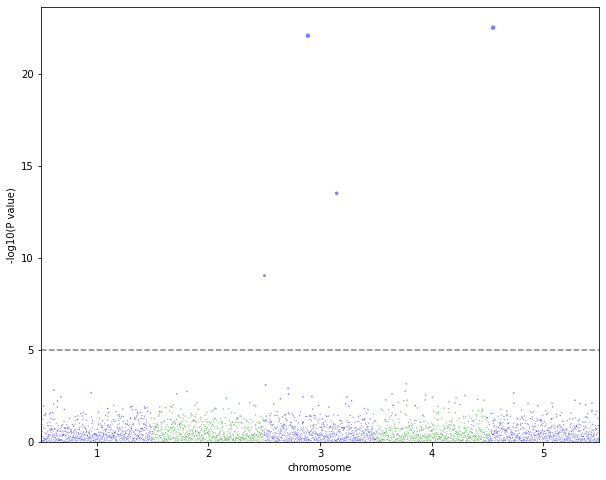

lambda=1.0078


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,2.990684e-23,0.418653,0.040052,0.424521,0,0.451117
1,392,snp1422_m0_.49m1_.5,3.0,2392.0,2392.0,8.251922e-23,-0.416495,0.040300,0.420587,0,0.279710
2,650,snp1200_m0_.37m1_.36,3.0,2650.0,2650.0,3.048007e-14,0.328870,0.042021,0.331240,0,0.279710
3,3,snp433_m0_.14m1_.11,3.0,2003.0,2003.0,9.202499e-10,-0.268289,0.042973,0.269670,0,0.279710
4,274,snp2832_m0_.46m1_.1,4.0,3274.0,3274.0,7.069762e-04,0.170421,0.050003,0.151124,0,0.542046
5,13,snp1413_m0_.04m1_.03,3.0,2013.0,2013.0,8.161238e-04,-0.148719,0.044157,0.149377,0,0.279710
6,214,snp2804_m0_.16m1_.3,3.0,2214.0,2214.0,1.239806e-03,0.150705,0.046396,0.144180,0,0.279710
7,117,snp751_m0_.04m1_.25,1.0,117.0,117.0,1.527432e-03,-0.152430,0.047827,0.141523,0,0.614963
8,265,snp1440_m0_.35m1_.32,4.0,3265.0,3265.0,1.771049e-03,0.136281,0.043358,0.139610,0,0.542046
9,307,snp2162_m0_.61m1_.42,2.0,1307.0,1307.0,1.816576e-03,-0.143296,0.045700,0.139280,0,0.534262


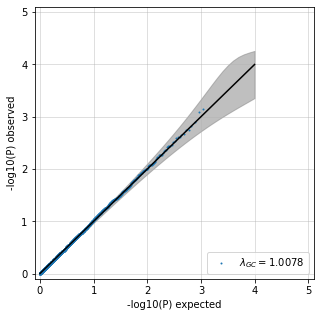

In [75]:

# set up data
##############################
from fastlmm.util import example_file # Download and return local file name
bed_fn = example_file('tests/datasets/synth/all.*','*.bed')
pheno_fn = example_file("tests/datasets/synth/pheno_10_causals.txt")
cov_fn = example_file("tests/datasets/synth/cov.txt")

# run gwas
###################################################################
results_df = single_snp(bed_fn, pheno_fn, covar=cov_fn, count_A1=False)

# manhattan plot
import pylab
import fastlmm.util.util as flutil
pylab.rcParams['figure.figsize'] = (10.0, 8.0)#For some reason, need again (appears above too) to get big figures
flutil.manhattan_plot(results_df[["Chr", "ChrPos", "PValue"]].values,pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

In [77]:
!wget cov_fn

--2022-05-25 10:52:20--  http://cov_fn/
Resolving cov_fn (cov_fn)... failed: Name or service not known.
wget: unable to resolve host address ‘cov_fn’


In [78]:
cov_fn

'/scratch/local/37123849/hashdown/3f3ec259205678626199fb0ab3b0803a/tests/datasets/synth/cov.txt'

In [83]:
pd.read_csv(cov_fn, sep='\t', header=None)

,0,1,2
0,cid0P0,cid0P0,0.548466
1,cid1P0,cid1P0,0.250912
2,cid2P0,cid2P0,-0.638701
3,cid3P0,cid3P0,0.480537
4,cid4P0,cid4P0,0.618070
...,...,...,...
495,cid495P1,cid495P1,-0.550367
496,cid496P1,cid496P1,-0.144458
497,cid497P1,cid497P1,-0.623505
498,cid498P1,cid498P1,1.054939


In [ ]:
from pysnptools.snpreader import Dense
from pysnptools.util import example_file # Download and return local file name
dense_file = example_file("pysnptools/examples/toydata100.dense.txt")
data_on_disk = Dense(dense_file)
print((data_on_disk.iid_count, data_on_disk.sid_count))

In [100]:
from pysnptools.snpreader import Dense
from pysnptools.util import example_file # Download and return local file name

In [237]:
pheno_sub = pheno.iloc[:100]

pheno_sub_df = pd.DataFrame({'id':list(pheno_sub.index), 'fam':pheno_sub.index, 'pheno': pheno_sub.pheno})

pheno_sub_df.to_csv('pheno_sub.txt', header=None, index=None, sep='\t')

In [246]:
geno_np = geno_t.cpu().numpy()

geno_np = geno_np.astype(int)

geno_np_sub = geno_np[:100, :500]
geno_np_sub.shape

geno_dense = [''.join([str(geno_np_sub[i,j]) for i in range(100)]) for j in range(500)]

pd.DataFrame(geno_dense, index=range(500)).to_csv("geno_dense.txt", sep='\t', header=False)

In [247]:
names = list(pheno_sub.index)

names.insert(0, 'var')

pd.DataFrame(names).T.to_csv('names.txt', sep='\t', header=None, index=None)

In [248]:
!cat names.txt geno_dense.txt > geno_dense_names.txt

In [256]:
from pysnptools.snpreader import Dense
from pysnptools.util import example_file # Download and return local file name

In [282]:
snp_reader = Dense('geno_dense_names.txt')

In [283]:
pheno_fn = 'pheno_sub.txt'

In [284]:
from fastlmm.association import single_snp_all_plus_select

results_df = single_snp_all_plus_select(snp_reader, pheno=pheno_fn, covar=None, count_A1=False)

AssertionError: no individuals remain after intersection, check that ids match in files

In [ ]:

bed_fn = example_file('tests/datasets/synth/all.*','*.bed')
snp_reader = Bed(bed_fn, count_A1=True)
pheno_fn = example_file("tests/datasets/synth/pheno_10_causals.txt")
cov_fn = example_file("tests/datasets/synth/cov.txt")

# find the chr5 SNPs
test_snps = snp_reader[:,snp_reader.pos[:,0] == 5]

#select the 2nd kernel and run GWAS
results_df = single_snp_all_plus_select(test_snps=test_snps,G=snp_reader,pheno=pheno_fn,GB_goal=2,do_plot=True,runner=runner)


In [260]:
from pysnptools.snpreader import Dense
from pysnptools.util import example_file # Download and return local file name
dense_file = example_file("pysnptools/examples/toydata100.dense.txt")
data_on_disk = Dense(dense_file)
print((data_on_disk.iid_count, data_on_disk.sid_count))

(500, 100)


In [264]:
data_on_disk.iid

array([['0', 'per0'],
       ['0', 'per1'],
       ['0', 'per2'],
       ['0', 'per3'],
       ['0', 'per4'],
       ['0', 'per5'],
       ['0', 'per6'],
       ['0', 'per7'],
       ['0', 'per8'],
       ['0', 'per9'],
       ['0', 'per10'],
       ['0', 'per11'],
       ['0', 'per12'],
       ['0', 'per13'],
       ['0', 'per14'],
       ['0', 'per15'],
       ['0', 'per16'],
       ['0', 'per17'],
       ['0', 'per18'],
       ['0', 'per19'],
       ['0', 'per20'],
       ['0', 'per21'],
       ['0', 'per22'],
       ['0', 'per23'],
       ['0', 'per24'],
       ['0', 'per25'],
       ['0', 'per26'],
       ['0', 'per27'],
       ['0', 'per28'],
       ['0', 'per29'],
       ['0', 'per30'],
       ['0', 'per31'],
       ['0', 'per32'],
       ['0', 'per33'],
       ['0', 'per34'],
       ['0', 'per35'],
       ['0', 'per36'],
       ['0', 'per37'],
       ['0', 'per38'],
       ['0', 'per39'],
       ['0', 'per40'],
       ['0', 'per41'],
       ['0', 'per42'],
       ['0', 'per43']

In [296]:
snp_reader.iid

array([['cid0P0', 'cid0P0'],
       ['cid1P0', 'cid1P0'],
       ['cid2P0', 'cid2P0'],
       ['cid3P0', 'cid3P0'],
       ['cid4P0', 'cid4P0'],
       ['cid5P0', 'cid5P0'],
       ['cid6P0', 'cid6P0'],
       ['cid7P0', 'cid7P0'],
       ['cid8P0', 'cid8P0'],
       ['cid9P0', 'cid9P0'],
       ['cid10P0', 'cid10P0'],
       ['cid11P0', 'cid11P0'],
       ['cid12P0', 'cid12P0'],
       ['cid13P0', 'cid13P0'],
       ['cid14P0', 'cid14P0'],
       ['cid15P0', 'cid15P0'],
       ['cid16P0', 'cid16P0'],
       ['cid17P0', 'cid17P0'],
       ['cid18P0', 'cid18P0'],
       ['cid19P0', 'cid19P0'],
       ['cid20P0', 'cid20P0'],
       ['cid21P0', 'cid21P0'],
       ['cid22P0', 'cid22P0'],
       ['cid23P0', 'cid23P0'],
       ['cid24P0', 'cid24P0'],
       ['cid25P0', 'cid25P0'],
       ['cid26P0', 'cid26P0'],
       ['cid27P0', 'cid27P0'],
       ['cid28P0', 'cid28P0'],
       ['cid29P0', 'cid29P0'],
       ['cid30P0', 'cid30P0'],
       ['cid31P0', 'cid31P0'],
       ['cid32P0', 'cid32P0'